# Count distribution in scRNA-seq data

We examine the marginal distribution of UMI counts in the raw single-nucleus RNA-seq data downloaded from http://resource.psychencode.org/. This count data is UMI-based, merged from two sources [Lake et al. (2018)](https://www.nature.com/articles/nbt.4038) and [Wang et al. (2018)](https://science.sciencemag.org/content/362/6420/eaat8464).

### Download data

In [1]:
using DelimitedFiles
using DataFrames
using Pipe
using Statistics
using RCall

In [2]:
;curl http://adult.psychencode.org/Datasets/Derived/SC_Decomp/DER-22_Single_cell_expression_raw_UMI.tsv --output DER-22_Single_cell_expression_raw_UMI.tsv

# download("http://adult.psychencode.org/Datasets/Derived/SC_Decomp/DER-22_Single_cell_expression_raw_UMI.tsv", "DER-22_Single_cell_expression_raw_UMI.tsv")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  898M  100  898M    0     0  5314k      0  0:02:53  0:02:53 --:--:-- 4808k0:03:31 6515k4  0:03:06 5444k 0:01:22  0:01:37 5877k  0  0:02:52  0:01:55  0:00:57 5954k0:02:54  0:02:28  0:00:26 6036k


### Load and munge data

In [3]:
lake_expr, cell_id = readdlm("DER-22_Single_cell_expression_raw_UMI.tsv", '\t'; header = true)
size(lake_expr)  # 27412 cells, 17176 genes

(17176, 27413)

In [4]:
cell_id = vec(cell_id[:, 1:(end-1)])
gene_id = lake_expr[:, 1]
lake_expr = transpose(lake_expr[:, 2:end]);

In [5]:
lake_expr = DataFrame(lake_expr)
rename!(lake_expr, string.(gene_id))
lake_expr[:, :cell_id] = cell_id
select!(lake_expr, r"cell_id", :);
# describe(lake_expr[:, 2:end], mean => :mean, std => :std)

In [6]:
lake_expr.level1class = copy(lake_expr.cell_id)
select!(lake_expr, r"level1", :)

lake_expr.level1class[occursin.("Ex", lake_expr.level1class), :] .= "ExcNeu"
lake_expr.level1class[occursin.("In", lake_expr.level1class), :] .= "InNeu"

idx = setdiff(collect(1:nrow(lake_expr)), collect(1:nrow(lake_expr)) .* occursin.("NA", lake_expr.cell_id))
lake_expr = lake_expr[idx, :];  # 27380 cells, 17176 genes

### Estimate mean and variance per gene and cell-type

In [7]:
df_adult = @pipe lake_expr |>
    stack(_, Not([:cell_id, :level1class]); variable_name = :gene, value_name = :UMI) |>
    groupby(_, [:level1class, :gene]) |>
    combine(_, :UMI => mean => "mean", :UMI => var => "variance", 
    :UMI => (x -> sum(x .== 0) / length(x)) => "zeros");

### Plot the relationship between mean and variance 

┌ Warning: RCall.jl: Warning: package ‘dplyr’ was built under R version 4.0.2
│ 
│ Attaching package: ‘dplyr’
│ 
│ The following objects are masked from ‘package:stats’:
│ 
│     filter, lag
│ 
│ The following objects are masked from ‘package:base’:
│ 
│     intersect, setdiff, setequal, union
│ 
└ @ RCall /Users/minsookim/.julia/packages/RCall/eRsxl/src/io.jl:160
┌ Warning: RCall.jl: Warning: package ‘ggplot2’ was built under R version 4.0.2
└ @ RCall /Users/minsookim/.julia/packages/RCall/eRsxl/src/io.jl:160


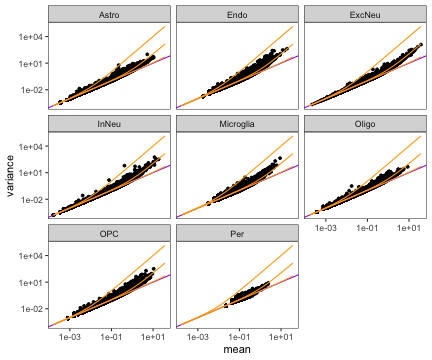

RObject{VecSxp}


In [8]:
R"""
library(dplyr)
library(ggplot2)

$df_adult %>% 
  filter(mean > 0) %>% 
  ggplot(aes(mean, variance)) +
  geom_point(size = 1) + 
  facet_wrap(level1class ~ .) +
  geom_abline(slope = 1, color = "purple") + 
  geom_function(fun = function(x) x + 0.01 * x^2, color = "orange") + 
  geom_function(fun = function(x) x + x^2, color = "orange") +
  geom_function(fun = function(x) x + 100 * x^2, color = "orange") +
  theme_bw() + 
  scale_x_log10() + 
  scale_y_log10() + 
  theme(panel.grid = element_blank())
"""

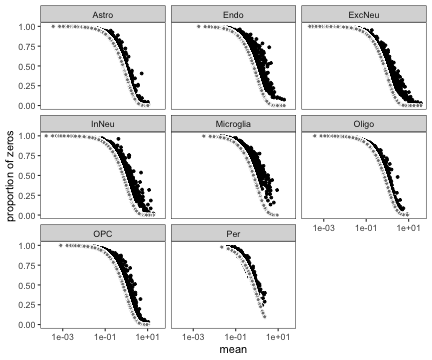

RObject{VecSxp}


In [9]:
R"""
$df_adult %>% 
  filter(mean > 0) %>% 
  mutate(expected = exp(-mean)) %>% 
  ggplot(aes(mean , zeros)) +
  geom_point(size = 1) + 
  geom_point(aes(mean, expected), fill = "grey50", color = "white", size = 1.5, pch = 21) + 
  facet_wrap(level1class ~ .) +
  scale_x_log10() + 
  theme_bw() + ylab("proportion of zeros") + 
  theme(panel.grid = element_blank())
"""

In theory, UMI counts per cell-type could be modeled as a Poisson distribution, if we assume that cells within the same cell-type are essentially technical replicates with minimal biological variability. However, most genes deviate significantly from the purple, identity line and instead lie closer to $\text{Var} = \mu + \phi \mu^2$, where $\phi = 1$. The other orange lines represent $\phi = 100$ and $0.01$. The proportion of cells with zero counts is also consistenly higher than the expected fraction shown in grey, again suggesting the inadequate fit of the Poisson distribution. 

Such an overdispersion could be due to multiple factors. First, there exists known cell subtype heterogeneity which can introduce additional variability in gene expression. Stratifying the cells further could help account for increased variance. Here, we also do not account for differences in read depth across cells, and the cells are actually from $\geq 4$ different individuals, which can all introduce additional variability in UMI counts.

In [58]:
versioninfo()

Julia Version 1.6.0
Commit f9720dc2eb (2021-03-24 12:55 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin19.6.0)
  CPU: Intel(R) Core(TM) i9-9880H CPU @ 2.30GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, skylake)
